***Exploratory Data Analysis***

In [322]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from joblib import load
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance

In [296]:
# Load dataset
df = pd.read_csv("data_from_obesity_db.csv")
df.head()

,id,gender,age,height_m,weight_kg,family_history_with_overweight,high_calorie_intake,vegetable_consumption,daily_meal_count,food_between_meals,smoking_habit,water_consumption,tracks_daily_calories,exercise_frequency,tech_usage_time,alcohol_intake,transportation_used,obesity_level
0,1,Female,21.0,1.62,64.0,True,False,2.0,3.0,Sometimes,False,2.0,False,0.0,1.0,no,Public_Transportation,Normal_Weight
1,2,Female,21.0,1.52,56.0,True,False,3.0,3.0,Sometimes,True,3.0,True,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,3,Male,23.0,1.80,77.0,True,False,2.0,3.0,Sometimes,False,2.0,False,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,4,Male,27.0,1.80,87.0,False,False,3.0,3.0,Sometimes,False,2.0,False,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,5,Male,22.0,1.78,89.8,False,False,2.0,1.0,Sometimes,False,2.0,False,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [297]:
# Dataset Overview
print("Dataset Overview:")
print(df.info())  # Data types and non-null counts
print("\nFirst few rows of the dataset:")
print(df.head())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              2111 non-null   int64  
 1   gender                          2111 non-null   object 
 2   age                             2111 non-null   float64
 3   height_m                        2111 non-null   float64
 4   weight_kg                       2111 non-null   float64
 5   family_history_with_overweight  2111 non-null   bool   
 6   high_calorie_intake             2111 non-null   bool   
 7   vegetable_consumption           2111 non-null   float64
 8   daily_meal_count                2111 non-null   float64
 9   food_between_meals              2111 non-null   object 
 10  smoking_habit                   2111 non-null   bool   
 11  water_consumption               2111 non-null   float64
 12  tracks_daily_cal

In [298]:
# Data Preprocessing
# Encoding categorical features
label_encoder = LabelEncoder()

# Example of encoding gender and obesity_level (you may need to encode other categorical variables similarly)
df['gender'] = label_encoder.fit_transform(df['gender'])  # Female: 0, Male: 1
df['family_history_with_overweight'] = df['family_history_with_overweight'].map({True: 1, False: 0}) 
df['high_calorie_intake'] = df['high_calorie_intake'].map({True: 1, False: 0}) 
df['food_between_meals'] = df['food_between_meals'].map({'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3})
df['smoking_habit'] = df['smoking_habit'].map({True: 1, False: 0})
df['tracks_daily_calories'] = df['tracks_daily_calories'].map({True: 1, False: 0})
df['alcohol_intake'] = df['alcohol_intake'].map({'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3})
df['transportation_used'] = df['transportation_used'].map({'Automobile': 1, 'Motorbike': 2, 'Bike': 3, 'Public_Transportation': 4, 'Walking': 5})

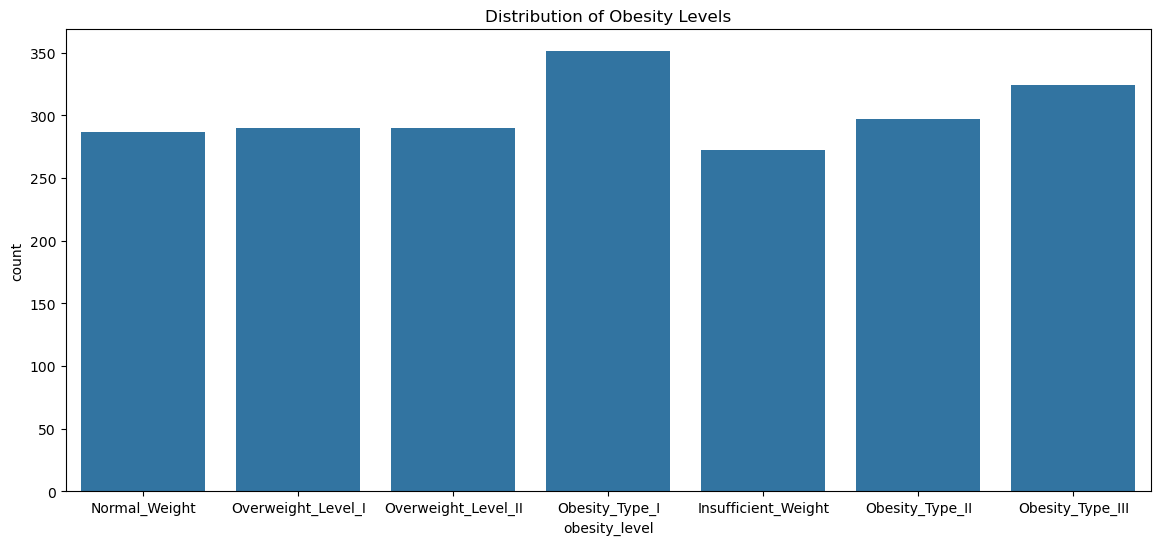

In [300]:
# Visualize the data
plt.figure(figsize=(14, 6))
sns.countplot(x='obesity_level', data=df)
plt.title('Distribution of Obesity Levels')
plt.show()

In [299]:

# Split the data into features and target variable
X = df.drop(columns=['obesity_level', 'id'])
y = df['obesity_level']

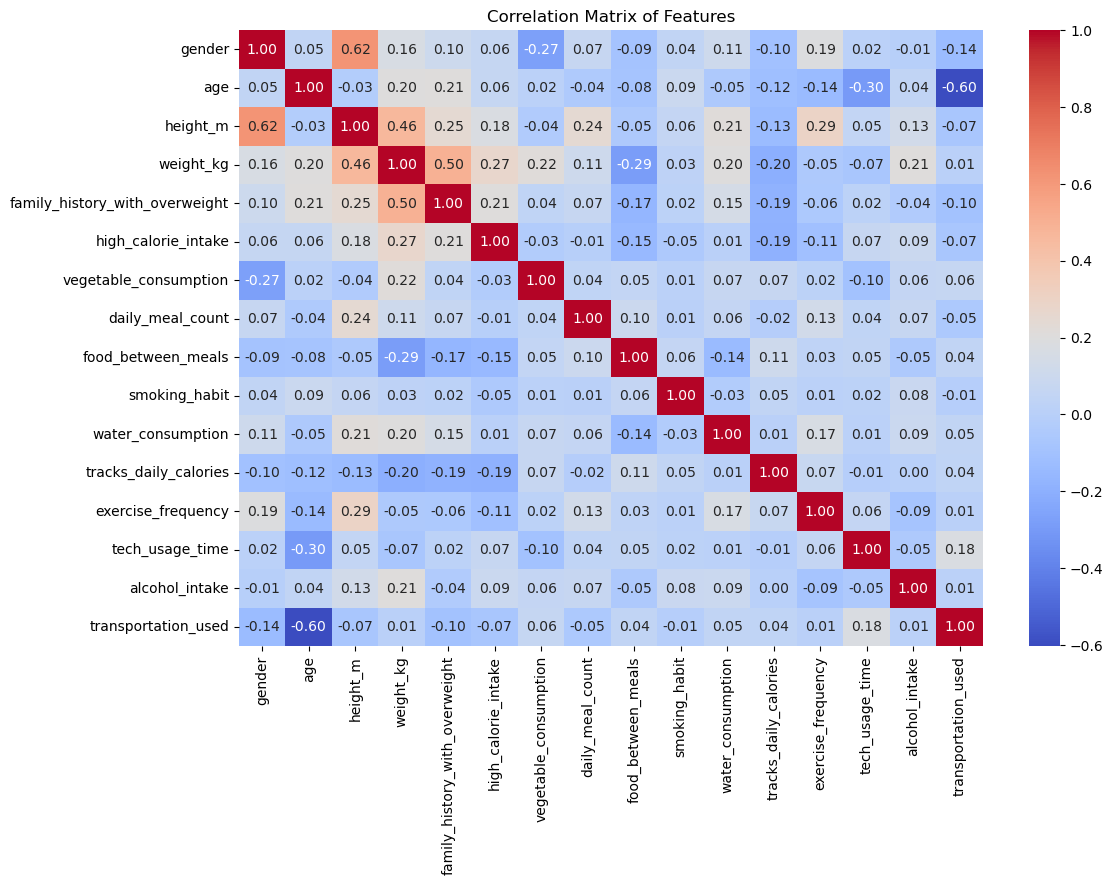

In [301]:
# Display correlation matrix
plt.figure(figsize=(12, 8))
corr_matrix = X.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix of Features")
plt.show()

**Key Observations:**

* **Strong Positive Correlations:**
    * **Weight & Height:**  A strong positive correlation (0.46) indicates that as height increases, weight tends to increase as well.
    * **Family History & Weight:** Individuals with a family history of overweight have a higher correlation with weight (0.50).
    * **High Calorie Intake & Weight:**  A moderate positive correlation (0.27) suggests that high-calorie intake is associated with higher weight.
    * **Food Between Meals & Weight:**  There's a negative correlation (-0.36) between weight and eating food between meals, which may indicate that frequent snacking is associated with lower weight. However, this correlation is likely influenced by other factors and should be interpreted with caution. 

* **Other Notable Correlations:**
    * **Age & BMI:** A moderate positive correlation (0.30) suggests that BMI tends to increase with age.
    * **Tech Usage Time & Age:** A strong positive correlation (0.60) between tech usage time and age is expected.
    * **Alcohol Intake & Tech Usage Time:** A moderate positive correlation (0.10) suggests that individuals with higher tech usage time may also tend to consume more alcohol.
    * **Transportation Used & Age:** A strong negative correlation (-0.60) between transportation used and age suggests that younger individuals may be more likely to use active transportation methods (walking, biking).

**Limitations:**

* **Correlation does not equal causation:** The matrix only shows correlations between variables. It doesn't establish a cause-and-effect relationship. 
* **Other factors:** Many other factors not included in this matrix can influence weight, such as lifestyle and socioeconomic status.

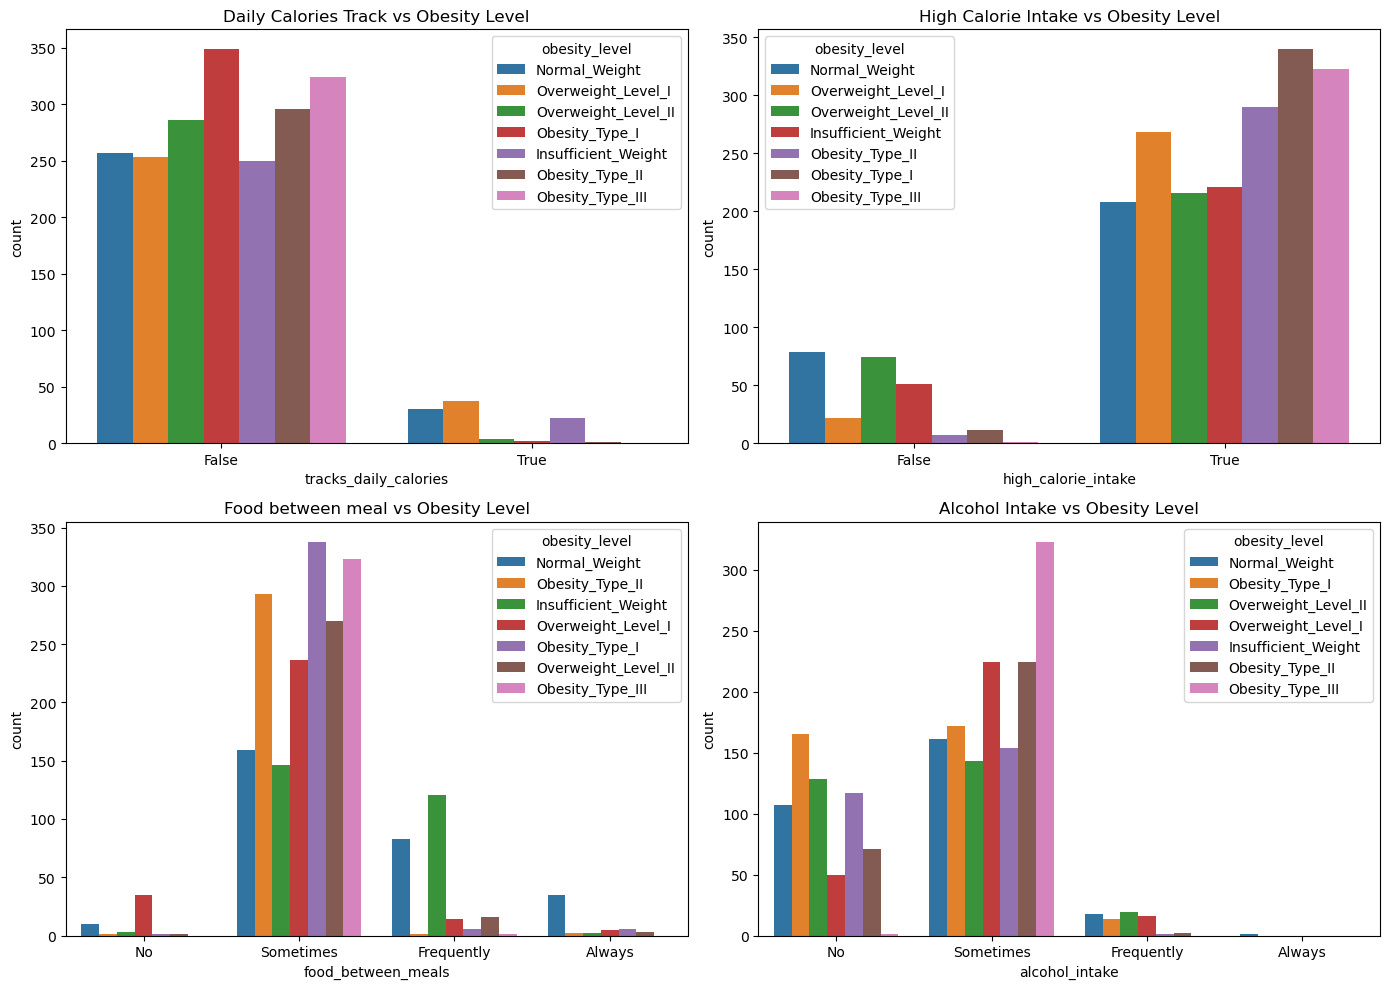

In [302]:

# Visualization: Distribution of lifestyle factors segmented by obesity classification (Food Focus)
plt.figure(figsize=(14, 10))

# Plot for 'tracks_daily_calories' by 'obesity_level'
plt.subplot(2, 2, 1)
sns.countplot(x='tracks_daily_calories', hue='obesity_level', data=df)
plt.title('Daily Calories Track vs Obesity Level')
plt.xticks(ticks=[0, 1], labels=['False', 'True'])

# Plot for 'high_calorie_intake' by 'obesity_level'
plt.subplot(2, 2, 2)
sns.countplot(x='high_calorie_intake', hue='obesity_level', data=df)
plt.title('High Calorie Intake vs Obesity Level')
plt.xticks(ticks=[0, 1], labels=['False', 'True'])

# Plot for 'food_between_meals' by 'obesity_level'
plt.subplot(2, 2, 3)
sns.countplot(x='food_between_meals', hue='obesity_level', data=df)
plt.title('Food between meal vs Obesity Level')
plt.xticks(ticks=[0, 1, 2, 3, ], labels=['No', 'Sometimes', 'Frequently', 'Always'])

# Plot for 'alcohol_intake' by 'obesity_level'
plt.subplot(2, 2, 4)
sns.countplot(x='alcohol_intake', hue='obesity_level', data=df)
plt.title('Alcohol Intake vs Obesity Level')
plt.xticks(ticks=[0, 1, 2, 3, ], labels=['No', 'Sometimes', 'Frequently', 'Always'])

plt.tight_layout()
plt.show()

**Analysis of the image:**


 * **Calorie Tracking:** Those who track calories tend to have lower obesity rates but we have to take in consideration that most don't even track.
 * **High Calorie Intake:** High-calorie intake is strongly linked to higher obesity risk.
 * **Snacking:** The Data shows that Normal_wight and Obesity_Type_I do it frequently while Insufficient_weight people snacking sometimes.
 * **Alcohol:** Most of the dataset show that they are not consuming alchole at all, so that's clearly means obesity has low correlation with Obesity.

**Important Note:** These are correlations, not causal relationships. Other factors like genetics and lifestyle also play a role in obesity.

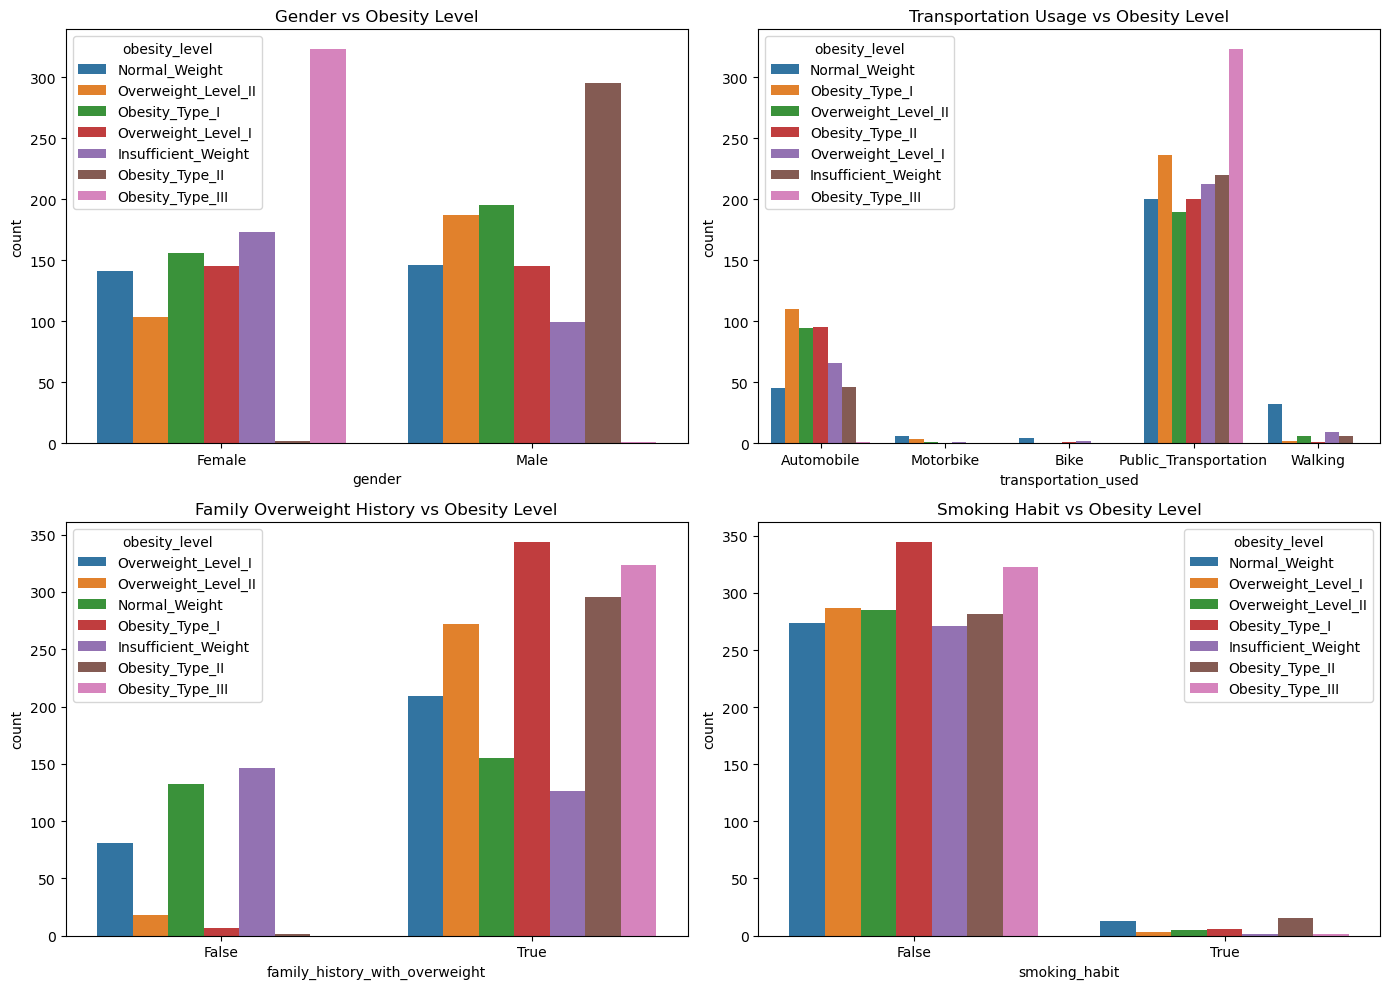

In [303]:

# Visualization: Distribution of lifestyle factors segmented by obesity classification (Habit Focus)
plt.figure(figsize=(14, 10))

# Plot for 'gender' by 'obesity_level'
plt.subplot(2, 2, 1)
sns.countplot(x='gender', hue='obesity_level', data=df)
plt.title('Gender vs Obesity Level')
plt.xticks(ticks=[0, 1], labels=['Female', 'Male'])

# Plot for 'transportation_used' by 'obesity_level'
plt.subplot(2, 2, 2)
sns.countplot(x='transportation_used', hue='obesity_level', data=df)
plt.title('Transportation Usage vs Obesity Level')
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=['Automobile', 'Motorbike', 'Bike', 'Public_Transportation', 'Walking'])

# Plot for 'family_history_with_overweight' by 'obesity_level'
plt.subplot(2, 2, 3)
sns.countplot(x='family_history_with_overweight', hue='obesity_level', data=df)
plt.title('Family Overweight History vs Obesity Level')
plt.xticks(ticks=[0, 1], labels=['False', 'True'])

# Plot for 'smoking_habit' by 'obesity_level'
plt.subplot(2, 2, 4)
sns.countplot(x='smoking_habit', hue='obesity_level', data=df)
plt.title('Smoking Habit vs Obesity Level')
plt.xticks(ticks=[0, 1], labels=['False', 'True'])

plt.tight_layout()
plt.show()

**Analysis of the image:**
 
* **Gender:** Obesity_Type_I is more pronuncing on Male while Obesity_Type_II is more on Female.
* **Transportation:** Automobile use is associated with higher obesity risk.
* **Family History:** Individuals with a family history of overweight are more likely to be overweight.
* **Smoking:** Smokers have a higher obesity risk but the correlation is very low on the overall dataset.

**Important Note:** These are correlations, not causal relationships. Other factors play a role. 


***Model Test and Train***

In [304]:
# Encode 'obesity_level' as an ordinal variable
obesity_mapping = {
    'Normal_Weight': 0,
    'Overweight_Level_I': 1,
    'Overweight_Level_II': 2,
    'Obesity_Type_I': 3,
    'Insufficient_Weight': 4,
    'Obesity_Type_II': 5,
    'Obesity_Type_III': 6
}
df['obesity_level'] = df['obesity_level'].map(obesity_mapping)

In [305]:
# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
id                                0
gender                            0
age                               0
height_m                          0
weight_kg                         0
family_history_with_overweight    0
high_calorie_intake               0
vegetable_consumption             0
daily_meal_count                  0
food_between_meals                0
smoking_habit                     0
water_consumption                 0
tracks_daily_calories             0
exercise_frequency                0
tech_usage_time                   0
alcohol_intake                    0
transportation_used               0
obesity_level                     0
dtype: int64


In [306]:
# Define models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use cross-validation and train models
best_models = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"Average CV Accuracy for {model_name}: {np.mean(cv_scores):.4f}")
    
    # Train the model on the full training set
    model.fit(X_train, y_train)
    best_models[model_name] = model

Training Random Forest...
Average CV Accuracy for Random Forest: 0.9520
Training Decision Tree...
Average CV Accuracy for Decision Tree: 0.9259
Training Gradient Boosting...
Average CV Accuracy for Gradient Boosting: 0.9544


In [307]:
# Initialize metrics dictionary
metrics = {}

for model_name, model in best_models.items():
    print(f"\nEvaluating {model_name}...")
    y_pred = model.predict(X_test)
    
    # Compute evaluation metrics
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    metrics[model_name] = {
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }
    
    # Print metrics
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")


Evaluating Random Forest...
Accuracy: 0.9433
Precision: 0.9436
Recall: 0.9433
F1 Score: 0.9434

Evaluating Decision Tree...
Accuracy: 0.9433
Precision: 0.9438
Recall: 0.9433
F1 Score: 0.9434

Evaluating Gradient Boosting...
Accuracy: 0.9456
Precision: 0.9464
Recall: 0.9456
F1 Score: 0.9454


In [308]:
# Display all metrics
print("\nSummary of Metrics:")
for model_name, scores in metrics.items():
    print(f"{model_name}: {scores}")


Summary of Metrics:
Random Forest: {'Accuracy': 0.9432624113475178, 'Precision': 0.9435772484100438, 'Recall': 0.9432624113475178, 'F1 Score': 0.9433706653340106}
Decision Tree: {'Accuracy': 0.9432624113475178, 'Precision': 0.9438025866250412, 'Recall': 0.9432624113475178, 'F1 Score': 0.9433620244829909}
Gradient Boosting: {'Accuracy': 0.9456264775413712, 'Precision': 0.9464357770958256, 'Recall': 0.9456264775413712, 'F1 Score': 0.9454129980627485}


C:\Users\jwidc\AppData\Local\Temp\ipykernel_3000\2192608989.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[sorted_idx], y=feature_names[sorted_idx], palette='viridis')


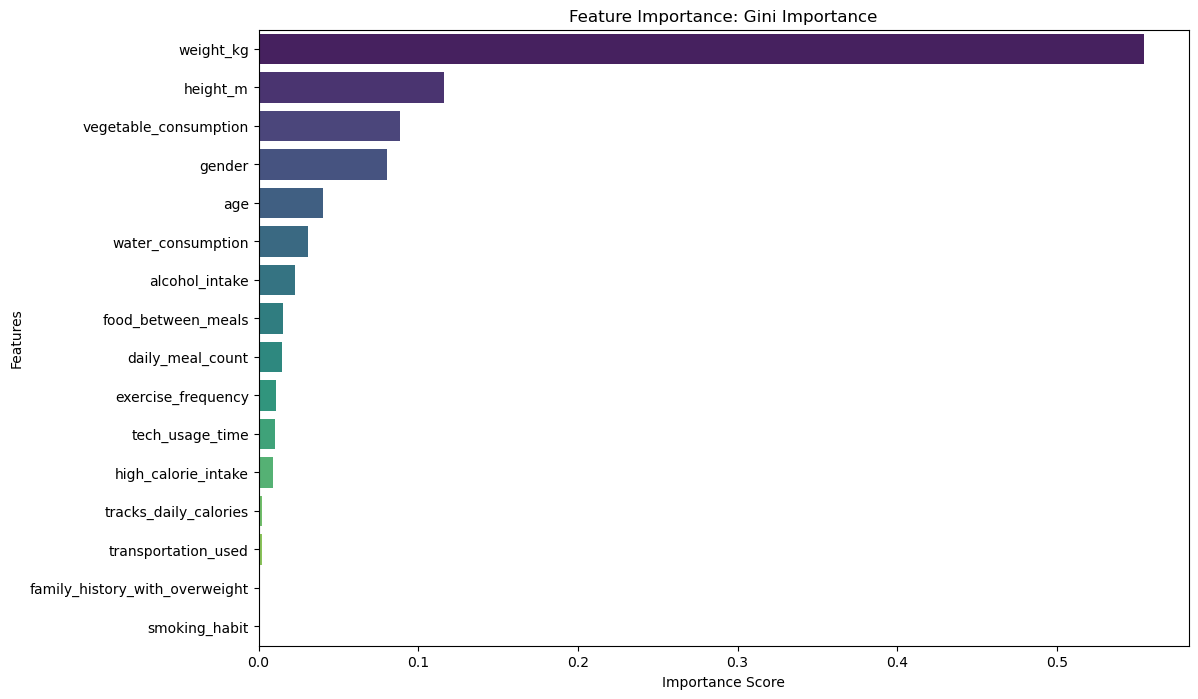

C:\Users\jwidc\AppData\Local\Temp\ipykernel_3000\2192608989.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=perm_importance.importances_mean[perm_sorted_idx], y=X.columns[perm_sorted_idx], palette='coolwarm')


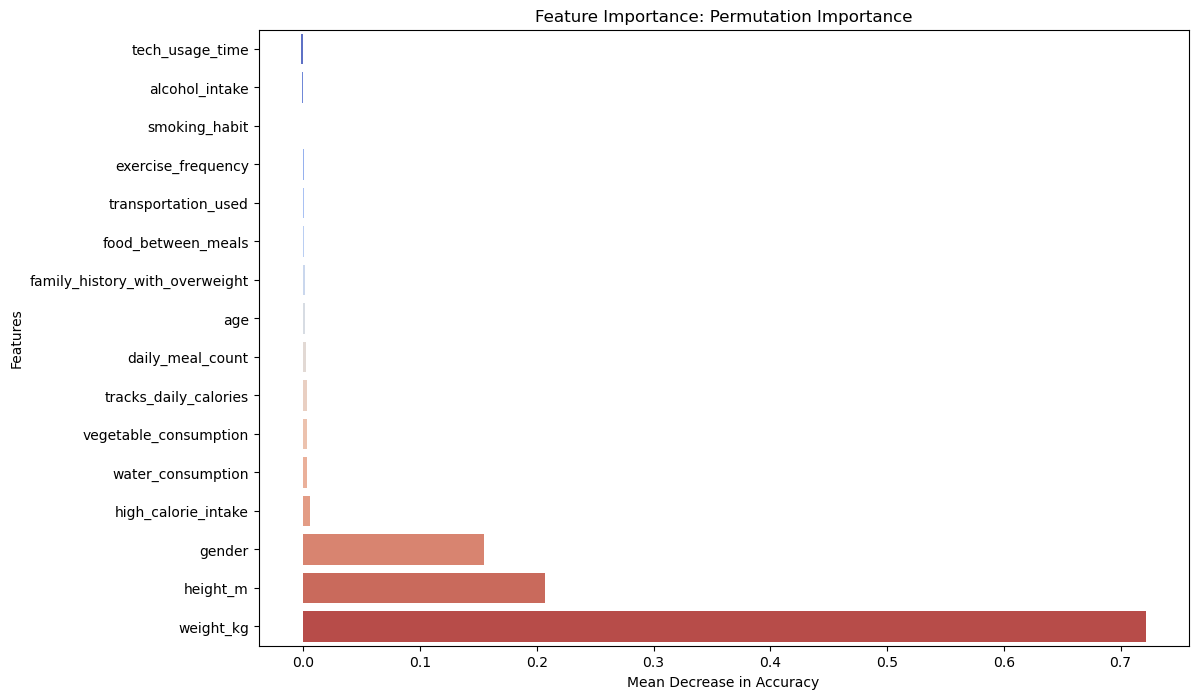

In [313]:
# Feature importance with Gradient Boosting as the best model based on metrics
best_model = best_models['Gradient Boosting']

# Built-in Feature Importance
plt.figure(figsize=(12, 8))
importances = best_model.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(importances)[::-1]

sns.barplot(x=importances[sorted_idx], y=feature_names[sorted_idx], palette='viridis')
plt.title("Feature Importance: Gini Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

# Permutation Importance
perm_importance = permutation_importance(best_model, X_test, y_test, scoring="accuracy", n_repeats=10, random_state=42)
perm_sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(12, 8))
sns.barplot(x=perm_importance.importances_mean[perm_sorted_idx], y=X.columns[perm_sorted_idx], palette='coolwarm')
plt.title("Feature Importance: Permutation Importance")
plt.xlabel("Mean Decrease in Accuracy")
plt.ylabel("Features")
plt.show()

In [311]:
# Hyperparameter grid for RandomForest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Set up GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV
print("Optimizing Random Forest...")
grid_search_rf.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search_rf.best_params_)
print("Best Cross-Validation Accuracy:", grid_search_rf.best_score_)

# Evaluate the optimized model on test data
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print("\nTest Accuracy of Optimized Random Forest:", accuracy_score(y_test, y_pred_rf))


Optimizing Random Forest...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Best Cross-Validation Accuracy: 0.9561656102400224

Test Accuracy of Optimized Random Forest: 0.950354609929078


In [314]:
# Define the parameter grid for GradientBoostingClassifier
gbc_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=42)

# Initialize GridSearchCV for GradientBoostingClassifier
gbc_grid_search = GridSearchCV(
    estimator=gbc,
    param_grid=gbc_param_grid,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Perform the grid search
print("Performing Grid Search for GradientBoostingClassifier...")
gbc_grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters for GradientBoostingClassifier:")
print(gbc_grid_search.best_params_)
print(f"Best cross-validation accuracy: {gbc_grid_search.best_score_:.4f}")

Performing Grid Search for GradientBoostingClassifier...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters for GradientBoostingClassifier:
{'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.9710


In [315]:
# Define the parameter grid for DecisionTreeClassifier
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Initialize DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV for DecisionTreeClassifier
dt_grid_search = GridSearchCV(
    estimator=dt,
    param_grid=dt_param_grid,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Perform the grid search
print("Performing Grid Search for DecisionTreeClassifier...")
dt_grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters for DecisionTreeClassifier:")
print(dt_grid_search.best_params_)
print(f"Best cross-validation accuracy: {dt_grid_search.best_score_:.4f}")


Performing Grid Search for DecisionTreeClassifier...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters for DecisionTreeClassifier:
{'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation accuracy: 0.9461


In [312]:
import joblib

# Save the model
joblib.dump(best_model, 'best_obesity_model.pkl')


['best_obesity_model.pkl']

In [324]:
# Save the model to a file
joblib.dump(best_model, 'best_gradient_boosting_model.pkl')

['best_gradient_boosting_model.pkl']